## Outlier Handling

In the section, we will take a deep dive into the outlier day that was identified in exploratory analysis, and decide on the handling method on data for that day.

In [1]:
from datetime import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

In [2]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

The date was 2013-11-30, and is under date_block_num 10 in the dataset

In [3]:
outlier = train_df.query('date_block_num == 10')

In [4]:
outlier.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
70,2013-11-20,10,25,"Москва ТРК ""Атриум""",8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
125,2013-11-30,10,22,Москва Магазин С21,8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
411,2013-11-01,10,54,"Химки ТЦ ""Мега""",8095,АВАТАР (BD+DVD),37,Кино - Blu-Ray,499.0,1.0,499.0
616,2013-11-16,10,27,"Москва ТЦ ""МЕГА Белая Дача II""",8266,АМЕРИКАНСКИЙ ПИРОГ. ВСЕ В СБОРЕ (BD),37,Кино - Blu-Ray,299.0,1.0,299.0
617,2013-11-04,10,27,"Москва ТЦ ""МЕГА Белая Дача II""",8266,АМЕРИКАНСКИЙ ПИРОГ. ВСЕ В СБОРЕ (BD),37,Кино - Blu-Ray,299.0,1.0,299.0


In [5]:
daily = outlier.groupby(['date'])['sales'].sum().reset_index()
daily.sort_values('sales', ascending=False).head()

,date,sales
28,2013-11-29,3.654481e+07
29,2013-11-30,8.475981e+06
1,2013-11-02,5.471740e+06
22,2013-11-23,5.277451e+06
21,2013-11-22,5.093426e+06


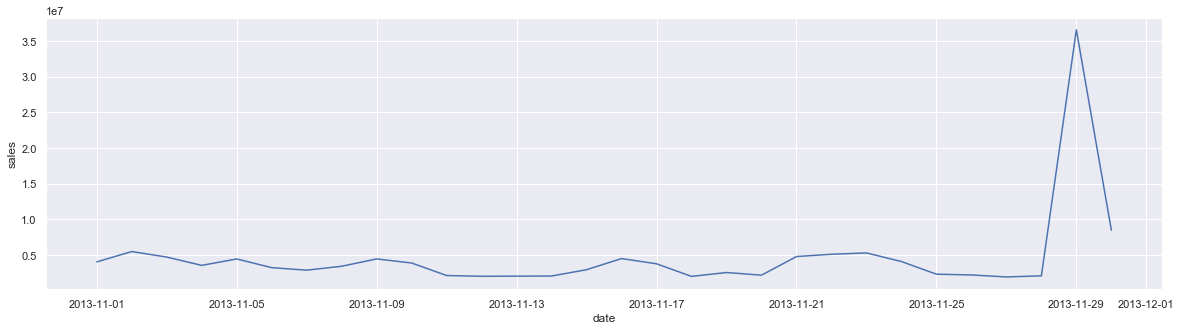

In [6]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='sales', data=daily, ci=None)
plt.show()

We want to understand if the sales spike is driven by specific products and/or store, or the spike happened to all variables. We will repeat the sub category extraction as we did in the exploratory analysis

In [7]:
cat_id = outlier.groupby(['date', 'item_category_name', 'item_category_id'])['sales'].sum().reset_index()
cat_id[['sub_cat', 'prod_name']] = cat_id['item_category_name'].str.split('-', n=1, expand=True)
cat_id['sub_cat'] = cat_id['sub_cat'].apply(lambda x: x.strip().lower())

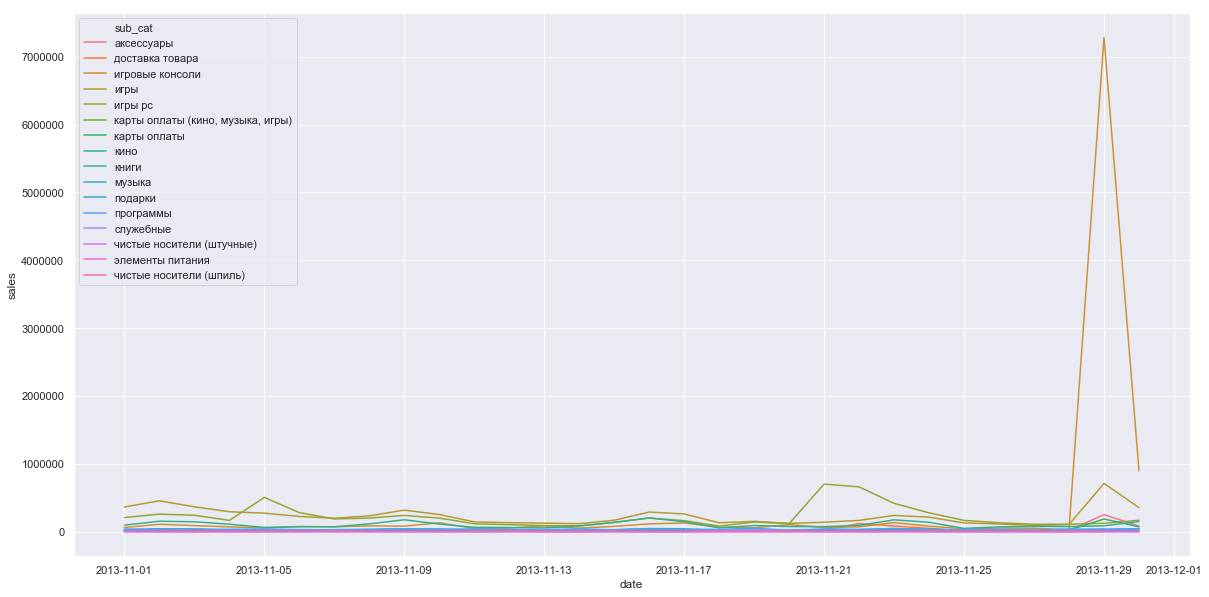

In [8]:
plt.figure(figsize = (20, 10))
sns.lineplot(x='date', y='sales', data=cat_id, hue='sub_cat', ci=None)
plt.show()

We can see that the sale split happened to a particular item_category игровые консоли.

In [9]:
cat_id_outliner = cat_id.query('sub_cat == "игровые консоли"')

Product category id as included in that category are

In [10]:
id_out = list(cat_id_outliner.item_category_id.unique())
id_out

[11, 14, 15, 12]

Now wee have a list of category id that cause the sales splike, we will look at the shop level to see if that only happen in specific shops

In [11]:
shop_outlier = outlier.groupby(['date', 'item_category_id', 'shop_id'])['sales'].sum().reset_index()

In [12]:
shop_outlier.head()

,date,item_category_id,shop_id,sales
0,2013-11-01,2,15,2590.0
1,2013-11-01,2,22,3290.0
2,2013-11-01,2,25,3180.0
3,2013-11-01,2,26,2490.0
4,2013-11-01,2,27,1290.0


In [13]:
shop_item_out = shop_outlier.query('item_category_id == @id_out')

In [14]:
shop_out = shop_item_out.groupby(['date','shop_id'])['sales'].sum().reset_index()

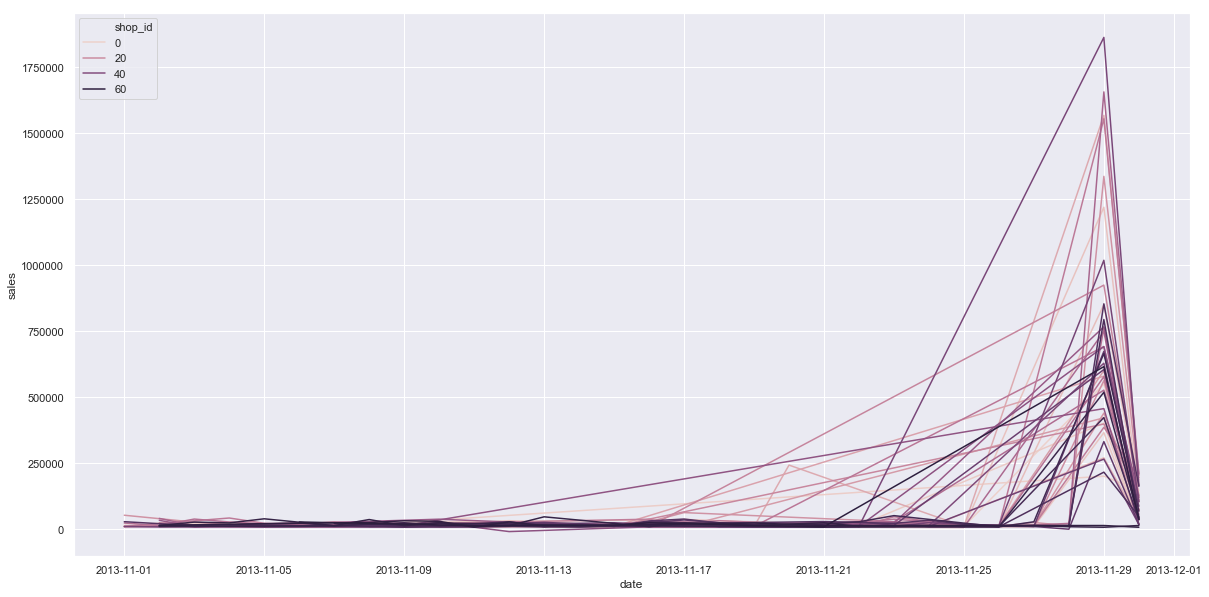

In [15]:
plt.figure(figsize = (20, 10))
sns.lineplot(x='date', y='sales', data=shop_out, hue='shop_id', ci=None)
plt.show()

The spike appear to happen at all shops. 

### Conclusion:

The sale spike was mainly occured at item categories 11, 12, 14, 15. It could be a result of big promotion on those items which we cannot tell from the data. We will classify them as one time event and would not factor that into the model. To replace the outlier, we replace record under 2013-10-29 for item category id 11, 12, 14, 15 with the sales average of 2013-10-28 and 2013-10-30.